# 1. Introduction and Problem Context


This project aims to develop a predictive regression model to estimate insurance premiums based on customer attributes such as income, health score, and other numerical and categorical information. Accurate prediction of premiums is crucial for the insurance industry to optimize pricing strategies and effectively manage risk.

The chosen model, LGBMRegressor, is well-suited for handling large datasets and capturing nonlinear relationships efficiently. Hyperparameter tuning using Optuna is applied to enhance model performance. The goal is to minimize the Root Mean Squared Logarithmic Error (RMSLE) and ensure the model generalizes well to new data.

As of writing this notebook, the model achieved a ranking of 196 out of 895 in the Kaggle competition, showcasing its competitive performance.

# 2. Loading and Inspecting the Data

In this section, we load the dataset and perform an initial inspection to understand its structure. We check basic statistics for outliers and missing values, identify the types of variables, and examine the first few records to gain a sense of the data quality.

### 2.1 Loading packages

In [1]:
# Helpful packages to load for data processing and machine learning
import os
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.model_selection import cross_val_score  # Cross-validation
from sklearn.pipeline import Pipeline  # Pipeline for model building
from sklearn.compose import ColumnTransformer  # Column transformer for preprocessing
from sklearn.impute import SimpleImputer  # Handling missing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling and encoding
from sklearn.model_selection import GridSearchCV, KFold  # Hyperparameter tuning and cross-validation
from sklearn.metrics import mean_squared_log_error  # Evaluation metric

import lightgbm as lgb  # LightGBM model
from sklearn.linear_model import LogisticRegression  # Logistic regression model

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Setting pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', '{:,.1f}'.format)  # Set float format to 1 decimal place


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 2.2 Loading data

In [2]:
import os
import pandas as pd  # Data processing, CSV file I/O
if 'KAGGLE_URL_BASE' in os.environ:
  for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
      print(os.path.join(dirname, filename))
  df_train_raw=pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
  df_test_raw=pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')


else:
  !pip install optuna
  df_train_raw=pd.read_csv('/content/train.csv')
  df_test_raw=pd.read_csv('/content/test.csv')

print("shape train:", df_train_raw.shape)
print("shape test:", df_test_raw.shape)
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
shape train: (1200000, 21)
shape test: (800000, 20)


## 2.3 Inspecting the Data

### 2.3.1 Preview the Data

The training set contains labeled data for supervised learning.

In [3]:
 df_train_raw.head(5)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,"10,049.0",Married,1.0,Bachelor's,Self-Employed,22.6,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.0"
1,1,39.0,Female,"31,678.0",Divorced,3.0,Master's,NaN,15.6,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.0"
2,2,23.0,Male,"25,602.0",Divorced,3.0,High School,Self-Employed,47.2,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,"141,855.0",Married,2.0,Bachelor's,NaN,10.9,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,"39,651.0",Single,1.0,Bachelor's,Self-Employed,20.4,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.0"


### 2.3.2 Data Types

"Policy Start Date" is stored in an incorrect format (likely as a string instead of a datetime). This could affect any time-based calculations or analyses. We'll convert it to the proper datetime format during preprocessing.

In [4]:
# Displaying data types of each column
df_train_raw.dtypes

,0
id,int64
Age,float64
Gender,object
Annual Income,float64
Marital Status,object
Number of Dependents,float64
Education Level,object
Occupation,object
Health Score,float64
Location,object


### 2.3.3 Basic statistics

For numerical features, all variables have reasonable ranges with no significant outliers. The ID columns contain unique values for identification purposes and will be removed, as they do not contribute to the model.

In [5]:
# Describing numerical features
df_train_raw.describe()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,"1,200,000.0","1,181,295.0","1,155,051.0","1,090,328.0","1,125,924.0","835,971.0","1,199,994.0","1,062,118.0","1,199,999.0","1,200,000.0"
mean,"599,999.5",41.1,"32,745.2",2.0,25.6,1.0,9.6,592.9,5.0,"1,102.5"
std,"346,410.3",13.5,"32,179.5",1.4,12.2,1.0,5.8,150.0,2.6,865.0
min,0.0,18.0,1.0,0.0,2.0,0.0,0.0,300.0,1.0,20.0
25%,"299,999.8",30.0,"8,001.0",1.0,15.9,0.0,5.0,468.0,3.0,514.0
50%,"599,999.5",41.0,"23,911.0",2.0,24.6,1.0,10.0,595.0,5.0,872.0
75%,"899,999.2",53.0,"44,634.0",3.0,34.5,2.0,15.0,721.0,7.0,"1,509.0"
max,"1,199,999.0",64.0,"149,997.0",4.0,59.0,9.0,19.0,849.0,9.0,"4,999.0"


Categorical features have a reasonable range of unique values (2 to 4), making them suitable for handling with one-hot or label encoding without the need for additional preprocessing.

In [6]:
# Describing object columns for categorical features
df_train_raw.describe(include='object')

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,1200000,1181471,1200000,841925,1200000,1200000,1200000,1122176,1200000,1200000,1200000
unique,2,3,4,3,3,3,167381,3,2,4,3
top,Male,Single,Master's,Employed,Suburban,Premium,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House
freq,602571,395391,303818,282750,401542,401846,142,377905,601873,306179,400349


### 2.3.4 Missing Values Analysis

The feature with the most missing values, "Previous Claims," has 30.3% missing. No column will be dropped for missing values. Numerical features will be imputed with the median (more stable than the mean), while categorical features will be replaced with the category "unknown."

In [7]:
# Checking for missing values
df_missing=pd.DataFrame({
    "null_num": df_train_raw.isna().sum(),
    "null_%": df_train_raw.isna().sum() / df_train_raw.shape[0] * 100,
    "dtype": df_train_raw.dtypes
})
df_missing[df_missing["null_%"]>0].sort_values(by="null_%", ascending=False)

,null_num,null_%,dtype
Previous Claims,364029,30.3,float64
Occupation,358075,29.8,object
Credit Score,137882,11.5,float64
Number of Dependents,109672,9.1,float64
Customer Feedback,77824,6.5,object
Health Score,74076,6.2,float64
Annual Income,44949,3.7,float64
Age,18705,1.6,float64
Marital Status,18529,1.5,object
Vehicle Age,6,0.0,float64


# 3. Feature Engineering

In this section, we perform several transformations and feature engineering. These include:

1.   Renaming Columns: We standardize column names by converting them to lowercase
and replacing spaces with underscores for consistency.
2.   Date Handling: The policy_start_date is converted to a datetime type, and several new features related to the date are created:

  *   Extract year, month, week, weekday, and day from the policy_start_date.
  *   Create cyclical features for day, week, and month using sine and cosine transformations to preserve the cyclical nature of these variables.

3.   Time Difference: We calculate the number of days from the policy_start_date to a specific date (e.g., "2024-12-31") as days_from_premium_date.
4.   Feature Ratios:
  *   ratio_incom_age, which represents the ratio of annual_income to age, clipped to avoid extreme values.
  *   income_per_dependent, dividing annual_income by the number of dependents, to capture income relative to dependents.
5.   Dropping Unnecessary Columns: The id column is dropped as it does not provide useful information for the model.


In [8]:
df_train_procesd=df_train_raw.copy()
df_test_procesd=df_test_raw.copy()

In [9]:
for df in [df_train_procesd, df_test_procesd]:
    # Renaming columns to lowercase and removing spaces
    df.columns = df.columns.str.replace(' ', '_').str.lower()

    # Converting 'policy_start_date' to datetime and extracting components
    df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], errors='coerce')
    df['policy_year'] = df['policy_start_date'].dt.year
    df['policy_month'] = df['policy_start_date'].dt.month
    df['policy_week'] = df['policy_start_date'].dt.isocalendar().week
    df['policy_week_day'] = df['policy_start_date'].dt.weekday
    df['policy_day'] = df['policy_start_date'].dt.day

    # Adding sin/cos transformations for cyclical features
    df['day_sin'] = np.sin(2 * np.pi * df['policy_day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['policy_day'] / 31)
    df['weekday_sin'] = np.sin(2 * np.pi * df['policy_week_day'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['policy_week_day'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['policy_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['policy_month'] / 12)

    # Calculating 'days_from_premium_date'
    df['days_from_premium_date'] = (pd.Timestamp("2024-12-31") - df['policy_start_date']).dt.days

    # Creating feature ratios
    df['ratio_incom_age'] = np.clip(df['annual_income'] / df['age'], a_min=1e-6, a_max=1e9)
    df['income_per_dependent'] = df['annual_income'] / (df['number_of_dependents'] + 1)

    # Dropping the 'id' column
    df.drop(['id'], axis=1, inplace=True)

Result:

In [10]:
df_train_procesd.head(3)

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount,policy_year,policy_month,policy_week,policy_week_day,policy_day,day_sin,day_cos,weekday_sin,weekday_cos,month_sin,month_cos,days_from_premium_date,ratio_incom_age,income_per_dependent
0,19.0,Female,"10,049.0",Married,1.0,Bachelor's,Self-Employed,22.6,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.0",2023,12,51,5,23,-1.0,-0.1,-1.0,-0.2,-0.0,1.0,373,528.9,"5,024.5"
1,39.0,Female,"31,678.0",Divorced,3.0,Master's,NaN,15.6,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.0",2023,6,24,0,12,0.7,-0.8,0.0,1.0,0.0,-1.0,567,812.3,"7,919.5"
2,23.0,Male,"25,602.0",Divorced,3.0,High School,Self-Employed,47.2,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,2023,9,39,5,30,-0.2,1.0,-1.0,-0.2,-1.0,-0.0,457,"1,113.1","6,400.5"


# 4. Exploratory Data Analysis (EDA)

During EDA, we examined the dataset to understand feature distributions and relationships:


1.   **Histograms:** Both Income and premium_amount are right-skewed, indicating the need for log transformations to normalize these variables.
2.   **Boxplots:** Categorical features show no clear patterns with premium_amount, but they were retained for modeling due to the possibility of complex relationships.
3.   **Correlation Matrix**: No strong linear correlations with the target were found, suggesting the need for non-linear models. Multicollinearity between some features was also observed.
4.   **Scatterplots:** No clear linear relationships were identified, further supporting the use of non-linear models such as Random Forest or LGBM.


The details below provide the specific visualizations and analyses that led to these conclusions.

In [11]:
df_numerical = df_train_procesd.select_dtypes(include=['number'])
df_categorical= df_train_procesd.select_dtypes(include=["object"])

## 4.1 Histograms (numerical features)

The 'Income' and 'premium_amount' features are both right-skewed with long tails, suggesting that a logarithmic transformation may be necessary to normalize these distributions and improve model performance.

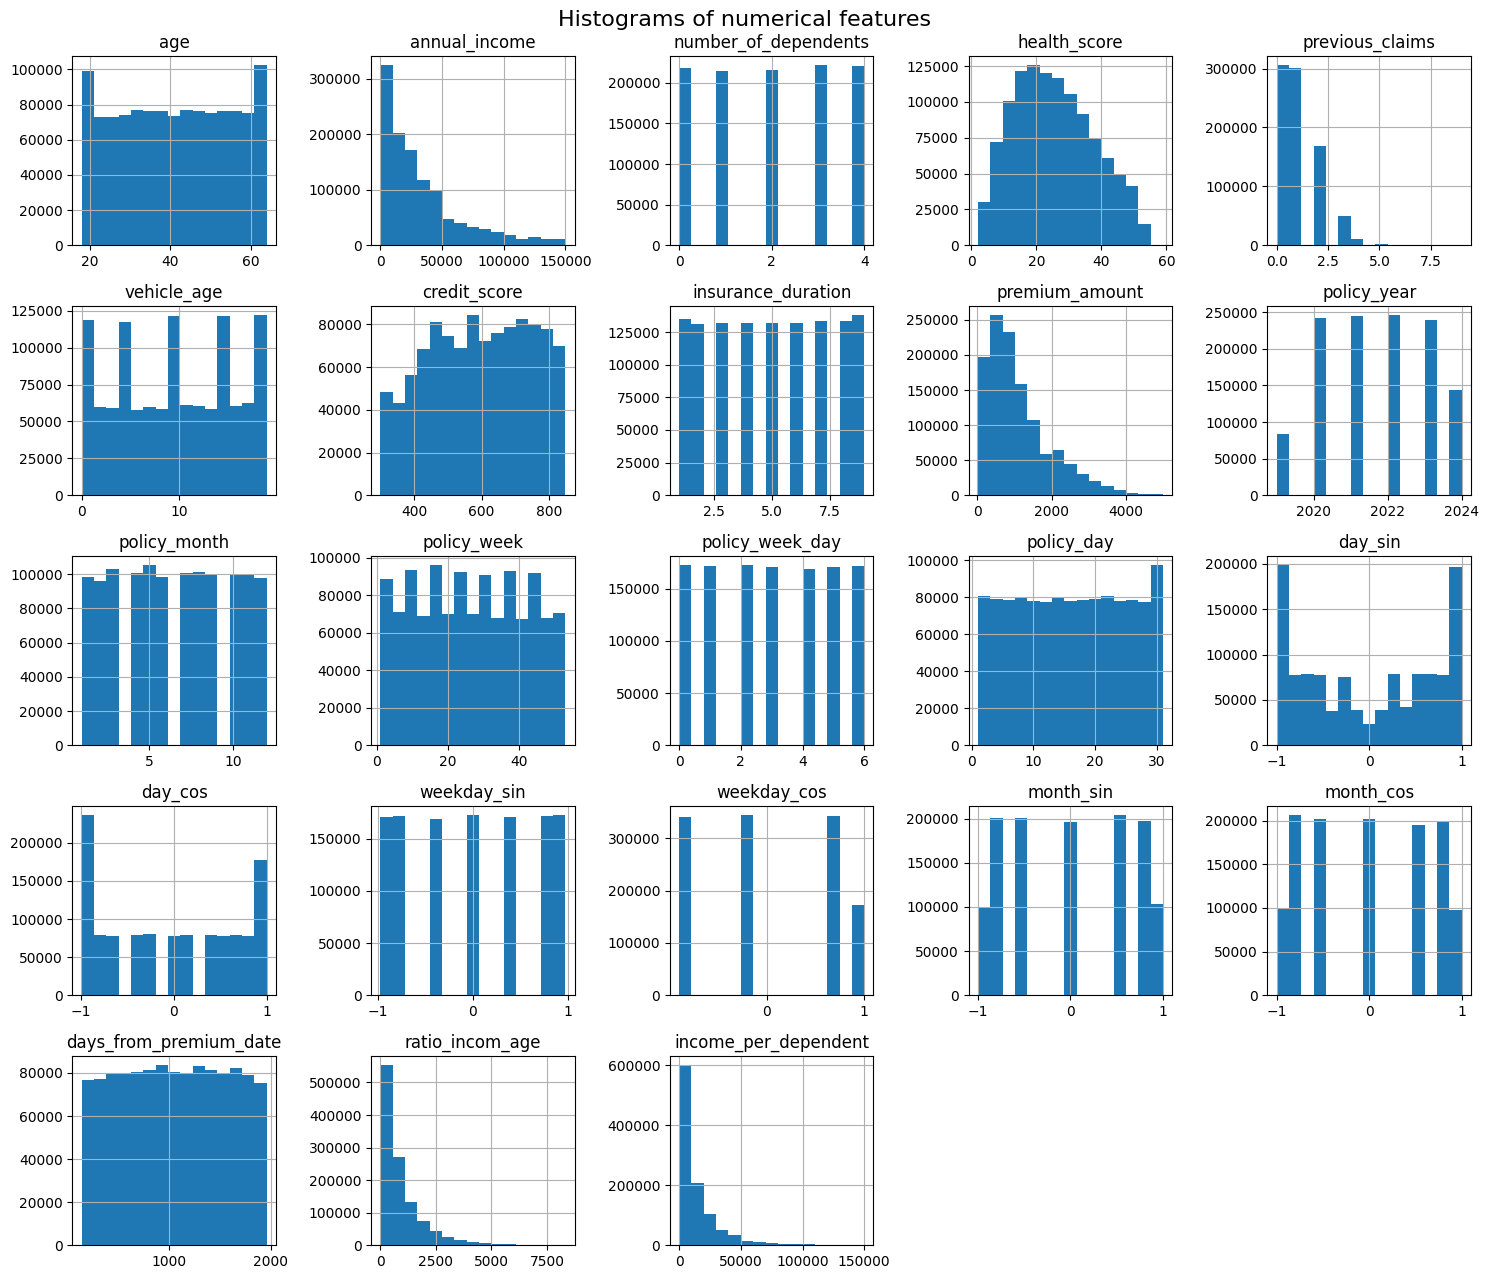

In [12]:
ax=df_numerical.hist(bins=15,figsize=(15, 13))
plt.suptitle('Histograms of numerical features', fontsize=16)
plt.tight_layout()
plt.show()

## 4.2 Boxplots (categorical features)

Visually (see 4.2.1 All Data), the categorical variables do not appear to significantly affect the target variable, as the distributions of the target across these categories are almost identical. Premium amounts greater than 3000 are treated as outliers.

A separate boxplot for this subset is shown below (see 4.2.2 Subset), which leads to the same conclusion. Despite this, we do not exclude categorical variables from the model, as there may be complex relationships with the target that are not captured by these plots.

In [13]:
# Function to plot boxplots for categorical variables against 'premium_amount'
def plot_boxplots(df_completo):
    df = df_completo.select_dtypes(include=["object"])  # Select categorical features
    n_cols = 2
    n_rows = -(-len(df.columns) // n_cols)  # Calculate number of rows for subplots

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 15))

    # Draw boxplots for each categorical feature against 'premium_amount'
    for ax, column in zip(axes.flatten(), df.columns):
        sns.boxplot(ax=ax, x=column, y='premium_amount', data=df_completo)
        ax.set_title(column)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


### 4.2.1 All data

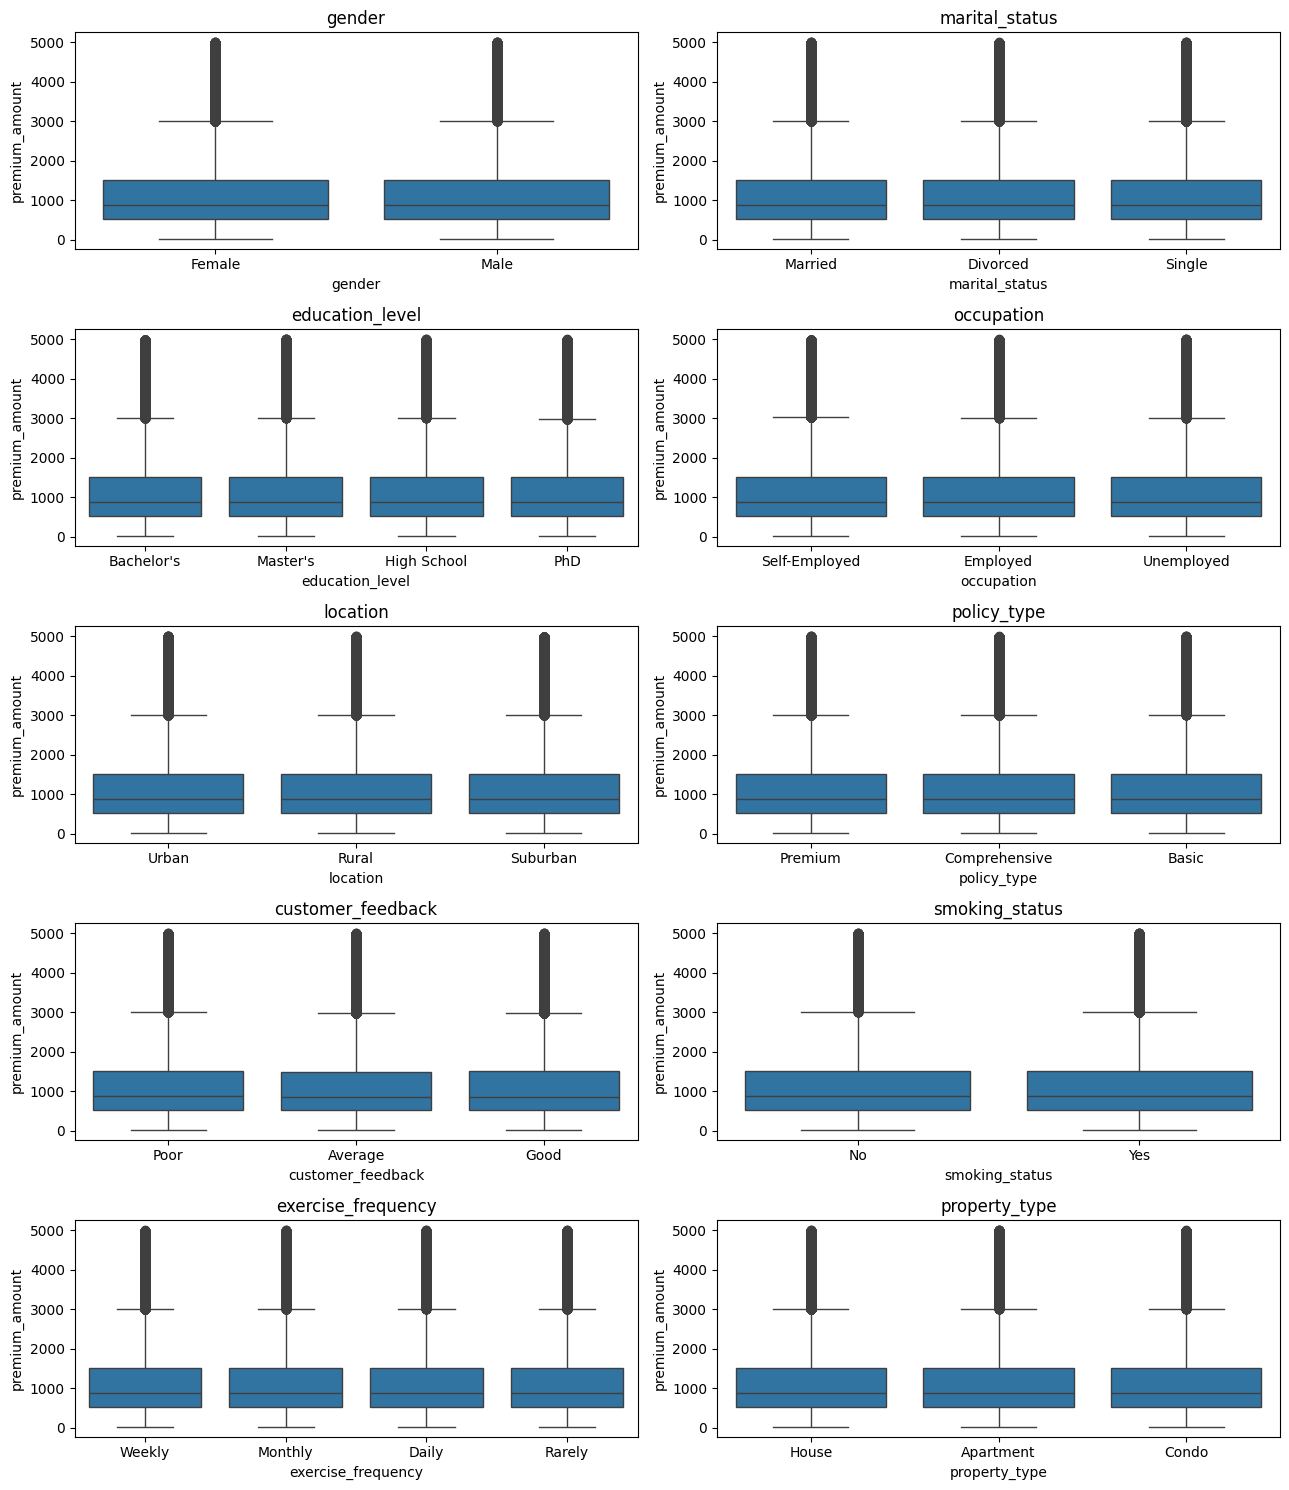

In [14]:
# Plot boxplots for all categorical variables
plot_boxplots(df_train_procesd)

### 4.2.2 Subset "premium_amount"]>=3000

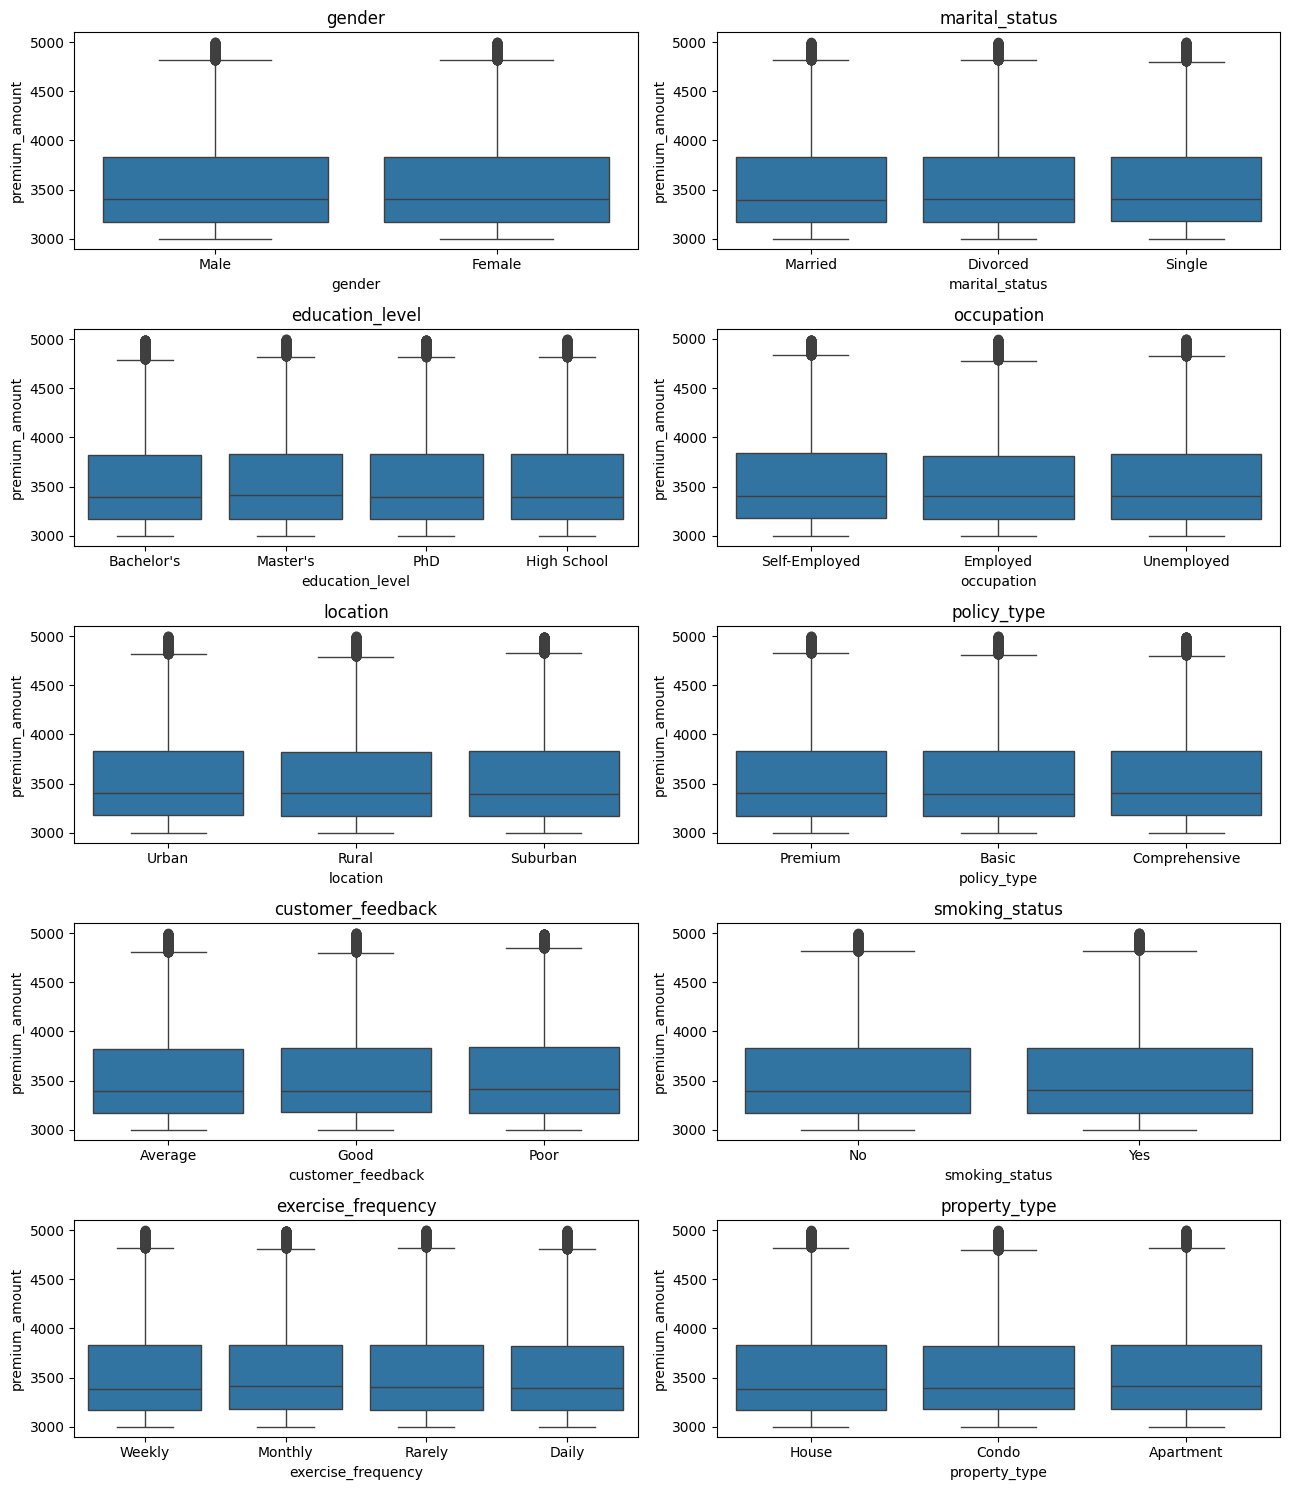

In [15]:
# Plot boxplots for rows with 'premium_amount' >= 3000
plot_boxplots(df_train_procesd[df_train_procesd["premium_amount"]>=3000])

## 4.3 Correlation Matrix

The correlation matrix does not reveal strong linear relationships between the target and numerical variables. However, non-linear relationships may exist that are not captured by this method. Therefore, low correlation values should not be a reason for eliminating variables.


Multicollinearity between some original columns and those created during feature engineering could harm the model. We will evaluate the importance of variables in each pair and remove redundant ones.

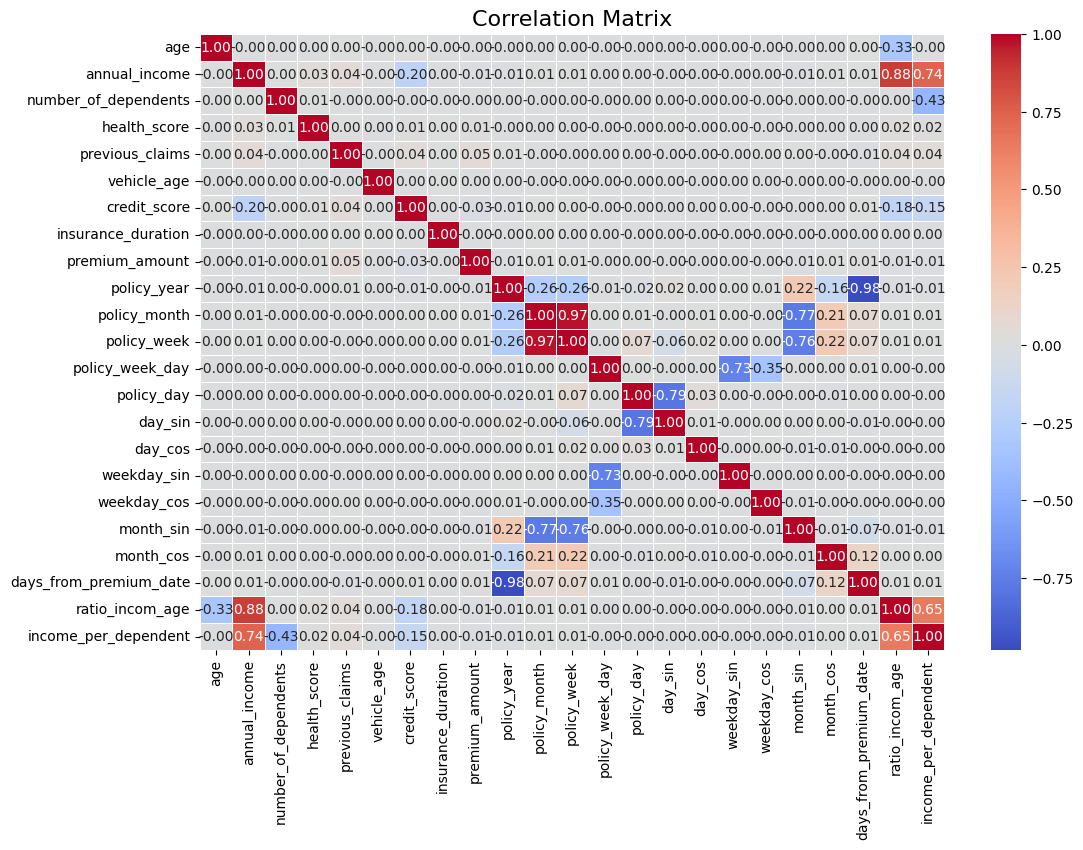

In [16]:
corr_matrix = df_numerical.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## 4.4 Scatterplots

There are no clear linear relationships between the variables and the target. This suggests that linear models, such as regression, may not be suitable. Non-linear models, like Random Forest or LGBM, could capture these complex relationships more effectively.

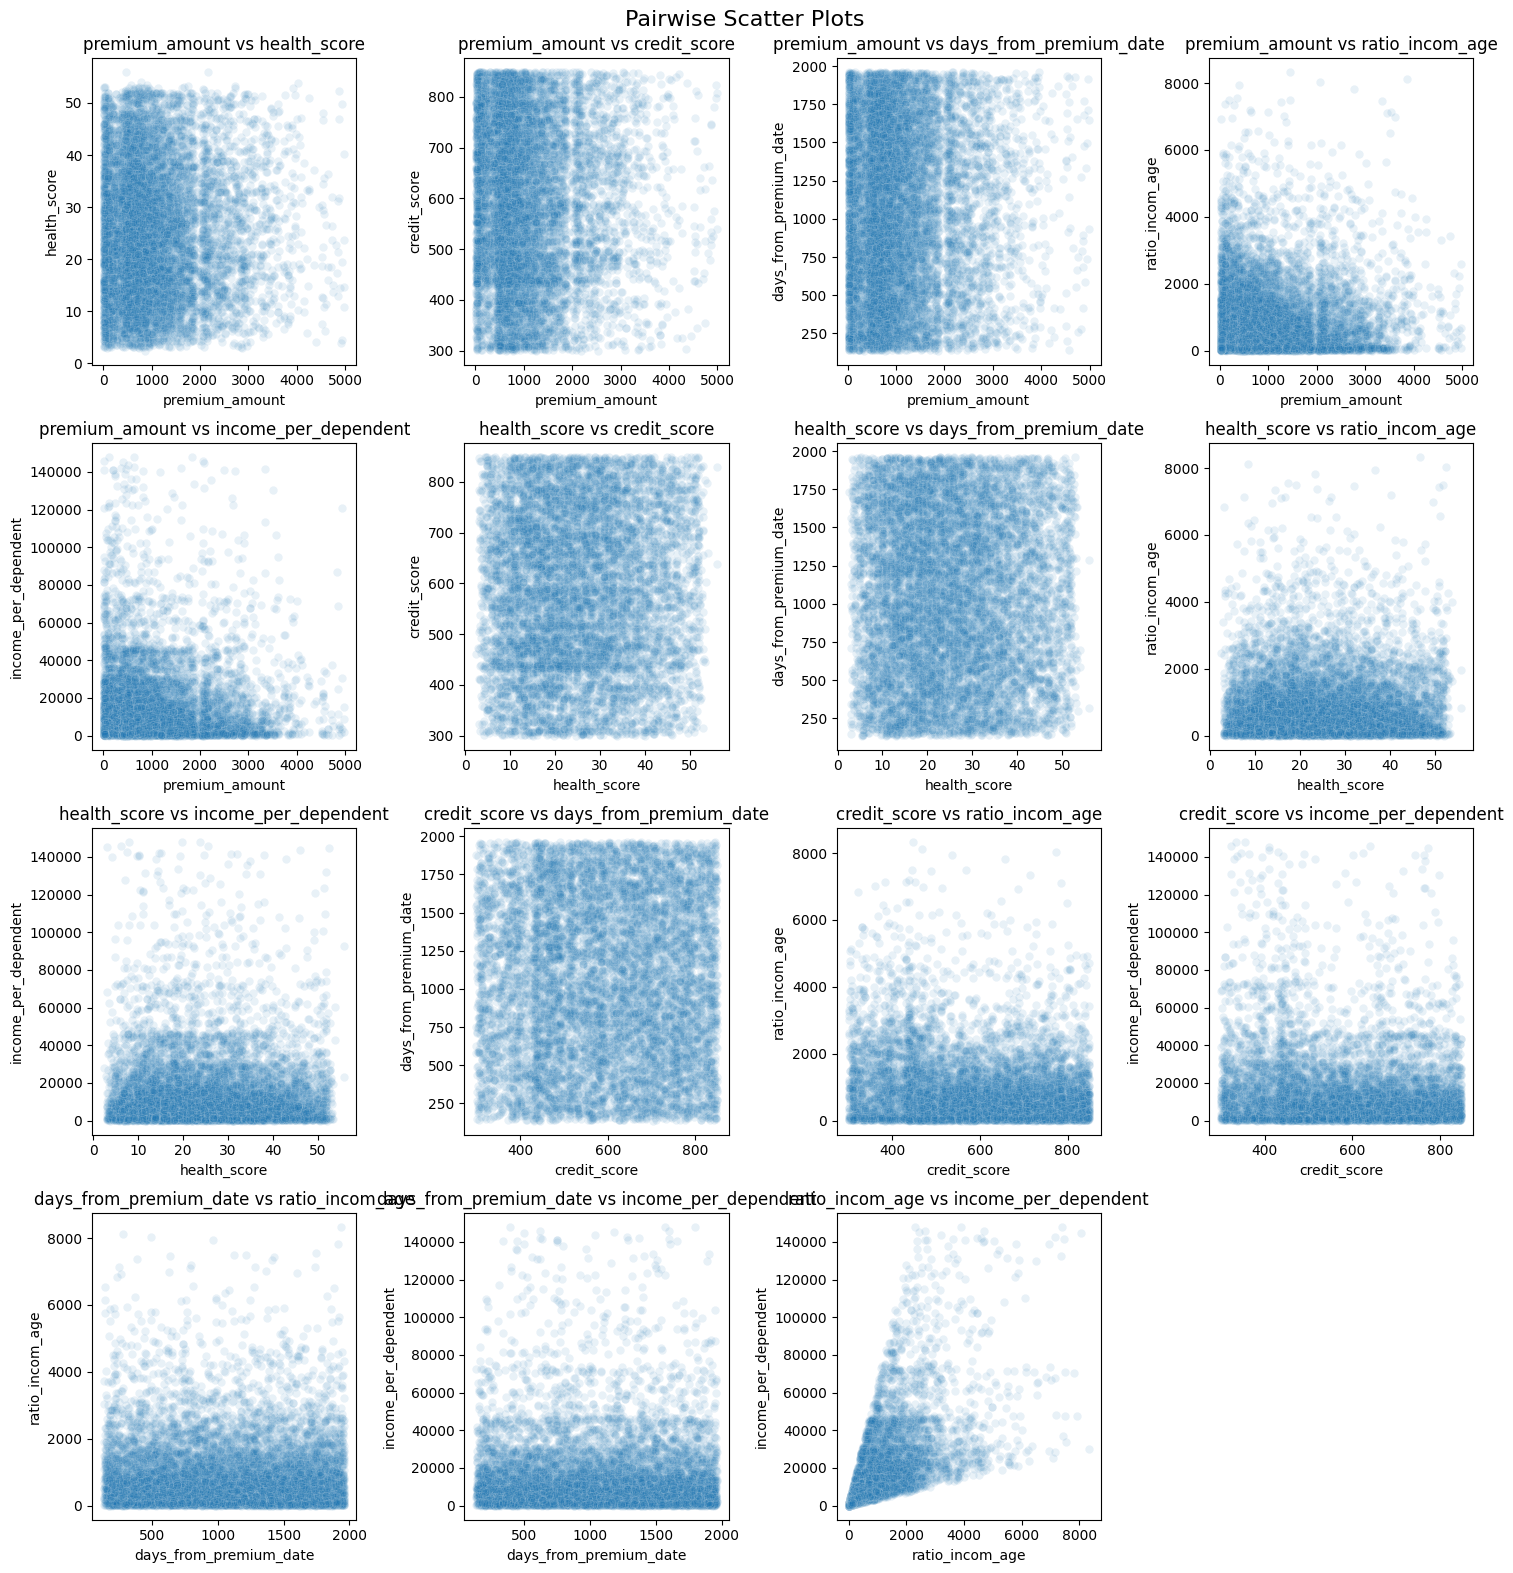

In [17]:
import itertools



columns_to_explore = ['premium_amount','health_score',
                      'credit_score', 'days_from_premium_date',  'ratio_incom_age',
                      'income_per_dependent']

df_limitado = df_numerical[columns_to_explore].sample(n=10000, random_state=42)


column_combinations = list(itertools.combinations(columns_to_explore, 2))


num_plots = len(column_combinations)
num_rows = (num_plots + 4 - 1) // 4  # Calcular el número de filas necesarias (máximo 4 columnas por fila)


fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

axes = axes.flatten()


for i, (col1, col2) in enumerate(column_combinations):
    ax = axes[i]
    sns.scatterplot(x=col1, y=col2, data=df_limitado, ax=ax, alpha=0.1)
    ax.set_title(f'{col1} vs {col2}')
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)


for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.suptitle('Pairwise Scatter Plots', fontsize=16)
plt.subplots_adjust(top=0.95)  # Ajustar el título principal para que no se solape con los subgráficos
plt.show()

# 5. Data Preprocessing

In this section, we apply the necessary transformations identified during the Exploratory Data Analysis (EDA) phase to prepare the data for modeling. These transformations include:



1.  **Log transformations:** Applied to Income and premium_amount to normalize their right-skewed distributions.
2.   **Handling null values:** Imputation of missing values for both numerical and categorical features.
3.   **Encoding categorical features:** One-hot encoding is used for categorical variables.
4.   **Standardization:** A StandardScaler is applied to numerical features to scale them to a similar range and improve model performance.
5. **Data splitting:** The dataset is divided into training, validation, and test sets.

Most of these steps, such as imputation, encoding, and standardization, are integrated into a scikit-learn **pipeline** to ensure consistent transformations during model training and evaluation.

In [18]:
df_train_engin=df_train_procesd.copy()
df_test_engin=df_test_procesd.copy()

## 5.1 Log Transformation

Based on the right-skewed distributions observed for certain variables, such as Income and premium_amount, we apply log transformations to make the distributions more normal. This transformation helps improve model performance, as confirmed through experiments conducted with this dataset.

In [19]:
for df in [df_train_engin,df_test_engin]:
    df['log_annual_income'] =np.log(df['annual_income']+1)
    df.drop('annual_income',axis=1,inplace=True)

df_train_engin['log_premium_amount'] =np.log(df_train_engin['premium_amount']+1)
df_train_engin.drop('premium_amount',axis=1,inplace=True)

## 5.2 Data Splitting (Training, Validation, and Test Sets)

In [20]:
# Splitting data into training and validation sets (80/20)
X_train_val, y_train_val= df_train_engin.drop('log_premium_amount',axis=1).copy(),\
    df_train_engin['log_premium_amount']
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

X_test=df_test_engin.copy()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(960000, 33) (960000,)
(240000, 33) (240000,)
(800000, 33)


## 5.3 Transformation in Pipline

We apply null imputing and encoding of categorical values, combining these transformations into a Scikit-learn pipeline. This ensures that the same transformations are applied to both the training and validation/test sets during model training.

In [21]:
# Preprocesamiento pipeline
numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                      ('scaler', StandardScaler())]), numerical_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
])

# 6. Model

In this section, we build, tune hyperparameters, and evaluate the model.

The **LGBMRegressor** model was chosen due to its efficiency in handling large datasets and its ability to capture nonlinear relationships. It offers a good balance between performance and computational cost.

Hyperparameter tuning was performed using **Optuna**, and after optimizing the parameters, the model was trained and evaluated. The results show good generalization with minimal overfitting.

# 6.1 Hyperparameter Tuning with Optuna

We use **Optuna** for hyperparameter optimization due to the large size of the dataset, and because this method is computationally efficient. The objective is to minimize the **Root Mean Squared Logarithmic Error (RMSLE**). The best parameters found are far from the limits of the selected search range, indicating that there is no need to adjust the range further. The number of trials was limited due to computational resource constraints. However, the optimization history plot shows no significant improvement after the fourth trial, which suggests that the result is acceptable and no further tuning is necessary.

In [22]:
%%capture
# Función objetivo para la optimización de Optuna
def objective(trial):
    # Parámetros definidos para la búsqueda
    param = {
        "objective": "regression",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),  # Tipo de boosting
        "num_leaves": trial.suggest_int("num_leaves", 200, 512),  # Número de hojas
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),  # Tasa de aprendizaje
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),  # Fracción de características
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),  # Fracción de muestras para el bagging
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),  # Frecuencia de bagging
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 200),  # Mínima cantidad de datos por hoja
        "max_depth": trial.suggest_int("max_depth", -1, 16),  # Profundidad máxima de los árboles
        #"device_type": "gpu",  # Usamos GPU para el entrenamiento
        "seed" : 42  # Semilla para la reproducibilidad
    }

    # Entrenamiento del modelo con los hiperparámetros seleccionados
    model = lgb.LGBMRegressor(**param)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Ajustar el modelo
    pipeline.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de validación
    y_pred = np.maximum(0, pipeline.predict(X_val))

    # Calcular el Mean Squared Logarithmic Error (MSLE)
    msle = mean_squared_log_error(y_val, y_pred)
    rmsle = np.sqrt(msle)
    return rmsle  # Optuna busca minimizar esta métrica

# Crear un estudio de optimización con Optuna
study = optuna.create_study(direction='minimize')  # Queremos minimizar MSLE
study.optimize(objective, n_trials=7)  # Realizamos 100 pruebas

# Mostrar los mejores parámetros y el mejor valor de la métrica
print(f"Best hyperparameters: {study.best_params}")
print(f"Best MSLE: {study.best_value}")

best_params = study.best_params

[I 2024-12-11 12:28:02,893] A new study created in memory with name: no-name-e4afb79a-0a4b-415c-86bf-846c874da4af
[I 2024-12-11 12:29:50,903] Trial 0 finished with value: 0.47098590797267076 and parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'learning_rate': 0.012771714724018012, 'feature_fraction': 0.8508875714300803, 'bagging_fraction': 0.8214668066881301, 'bagging_freq': 12, 'min_data_in_leaf': 55, 'max_depth': 9}. Best is trial 0 with value: 0.47098590797267076.
[I 2024-12-11 12:31:25,589] Trial 1 finished with value: 0.6724828302254307 and parameters: {'boosting_type': 'dart', 'num_leaves': 508, 'learning_rate': 0.0020596360932896764, 'feature_fraction': 0.8285511517482436, 'bagging_fraction': 0.5579493814078575, 'bagging_freq': 11, 'min_data_in_leaf': 182, 'max_depth': 8}. Best is trial 0 with value: 0.47098590797267076.
[I 2024-12-11 12:31:51,309] Trial 2 finished with value: 0.16494225826452438 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 466, 'learning_rat

In [23]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


In [24]:
best_params={'boosting_type': 'gbdt',
             'num_leaves': 385,
             'learning_rate': 0.01962545424029374,
             'feature_fraction': 0.9809422205650686,
             'bagging_fraction': 0.8928745516778743,
             'bagging_freq': 5,
             'min_data_in_leaf': 147,
             'max_depth': 14}

# 6.2 Model Building

After finding the best hyperparameters through Optuna, we train the final model using the selected parameters.

In [25]:
%%capture
final_model = lgb.LGBMRegressor(**best_params, verbose=0)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', final_model)])
final_pipeline.fit(X_train, y_train)


# 6.3 Model Evaluation

We evaluate the model using the Root Mean Squared Logarithmic Error (RMSLE). Predictions are made on both the training and validation sets, and the predicted values are then converted back to the original scale due to the earlier log transformation of the target variable.

The RMSLE for the validation set is slightly worse than that of the training set, which suggests that there is no drastic overfitting. This indicates that the model generalizes reasonably well on unseen data.

In [26]:
# Predict on training and validation sets
y_train_pred = final_pipeline.predict(X_train)
y_val_pred = final_pipeline.predict(X_val)

# Convertir las predicciones al espacio original
y_train_pred_original = np.exp(y_train_pred) - 1
y_val_pred_original = np.exp(y_val_pred) - 1

# Convertir target logaritmico al espacio original
y_train_original=np.exp(y_train) - 1
y_val_original=np.exp(y_val)-1


# Calcular RMSLE usando los valores originales y predicciones en el espacio original
from sklearn.metrics import mean_squared_log_error
rmsle_train = np.sqrt(mean_squared_log_error(y_train_original, y_train_pred_original))
rmsle_val = np.sqrt(mean_squared_log_error(y_val_original, y_val_pred_original))

# Imprimir resultados
print(f"RMSLE train: {rmsle_train}, RMSLE validation: {rmsle_val}")

[LightGBM] [Warning] feature_fraction is set=0.9809422205650686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809422205650686
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] bagging_fraction is set=0.8928745516778743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8928745516778743
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9809422205650686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809422205650686
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] bagging_fraction is set=0.8928745516778743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8928745516778743
[LightGBM] [Warning] bagging_freq is set=5

# 6.4 Final Predictions & Submission

In [27]:
# Make predictions on the test set
y_test_pred = final_pipeline.predict(X_test)
y_test_pred_original = np.exp(y_test_pred) - 1
# Create submission DataFrame
submission = pd.DataFrame({'id': df_test_raw['id'], 'Premium Amount': y_test_pred_original})

# Save submission as CSV
submission.to_csv("submission.csv", index=False)
print("Done")

[LightGBM] [Warning] feature_fraction is set=0.9809422205650686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809422205650686
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] bagging_fraction is set=0.8928745516778743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8928745516778743
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Done


# 7. Result

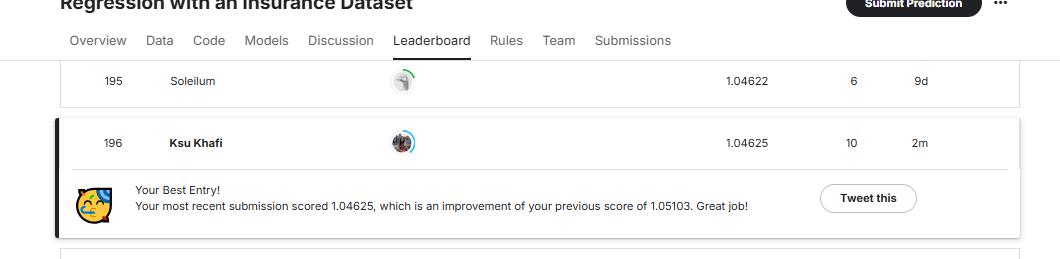